# day 282,day 283,day 288,day 290,day 292,day 294,day 297,day301,day 304

# George Hotz says our goal as an Engineer is:

1. Read a paper.
2. Implement what is in the paper.
3. keep repeating it until you have mastered the contents of the paper.



# why document classification a many to one problem?
* Because we are taking many inputs from the document and finally classify them under a single label or a format that is why it is a many to one problem.
* in the medical abstract document projects we are to take the words of the abstract document and then classify the words(many) to one label either as Introduction or Background or Methods used or Results or Conclusion. see we use `or` not `and` to imply that it is going to go to one of them not all of them at a time.

![sfsdfs](https://goodboychan.github.io/images/copied_from_nb/image/many-to-one.png)

# goals:

1. download the text dataset
2. preprocess the text dataset.
3. create multiple modelling experiments with `different levels of embeddings.`
4. create a `multimodal model` to take in differnt sources of data.
5. find the most wrong prediction.

# 1. Download the data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 29.88 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [ ]:
!ls -ltr pubmed-rct

total 20
drwxr-xr-x 2 root root 4096 Feb  3 15:09 PubMed_200k_RCT
drwxr-xr-x 2 root root 4096 Feb  3 15:09 PubMed_200k_RCT_numbers_replaced_with_at_sign
drwxr-xr-x 2 root root 4096 Feb  3 15:09 PubMed_20k_RCT
drwxr-xr-x 2 root root 4096 Feb  3 15:09 PubMed_20k_RCT_numbers_replaced_with_at_sign
-rw-r--r-- 1 root root 3695 Feb  3 15:09 README.md


## import the essentials

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os,requests,zipfile
from pathlib import Path
import pandas as pd

## explore the files

In [ ]:
os.listdir('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign')

['train.txt', 'test.txt', 'dev.txt']

In [ ]:
# achieving the same result in linux
!ls -ltr pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

total 37664
-rw-r--r-- 1 root root  4845197 Feb  3 15:09 dev.txt
-rw-r--r-- 1 root root  4811369 Feb  3 15:09 test.txt
-rw-r--r-- 1 root root 28908792 Feb  3 15:09 train.txt


In [ ]:
# get the files to work with;

data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'
file_paths = [data_dir + '/' + files for files in os.listdir('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign')]
file_paths

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [ ]:
# read the text from files:
def get_lines(file_name):
  """
  Args: it takes a text file

  returns: returns it line by line

  """
  with open(file_name,'r') as f:
    return f.readlines()

train_txt = file_paths[0]
train_lines = get_lines(train_txt)


In [ ]:
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [ ]:
len(train_lines)

210040

## data formating

### this is how we want our data to look:

```python
{['line_number':2,
  'target': 'Background',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'total_lines in that cohort': 11]}
  ```

* we have to do this process for each of those 210,040 lines getting each line a dictionary like the one above.

In [ ]:
def preprocess_text(text):
  abstract_lines = ''
  abstract_samples = []

  for line in text:
    if line.startswith('###'):
      abstract_id = line # we are not going to do anything with this(we are throwing it away)
      abstract_lines = '' # reset the abstract_lines if the line is id line

    elif line.isspace(): # if the line is a new line, you will get list of new lines of strings
      abstract_line_split = abstract_lines.splitlines()

      # iterate through each of these lines and create line properties as proposed above
      for line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # for storing the properties.

        line_data['line_number'] = line_number
        target_text_split = abstract_line.split('\t') # split by the \t
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['total_lines'] = len(abstract_line_split)-1 # start from 0

        # append the line_data to abstract_samples list
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples





In [ ]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

train_dir = data_dir + '/train.txt'
test_dir = data_dir + '/test.txt'
val_dir = data_dir + '/dev.txt'

train_text = get_lines(train_dir)
test_text = get_lines(test_dir)
val_text = get_lines(val_dir)

# preprocessed train,test,val
train_text_pre = preprocess_text(train_text)
test_text_pre = preprocess_text(test_text)
val_text_pre = preprocess_text(val_text)

In [ ]:
# creating data frames
train_df = pd.DataFrame(train_text_pre)
test_df = pd.DataFrame(test_text_pre)
val_df = pd.DataFrame(val_text_pre)
train_df.head(15)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


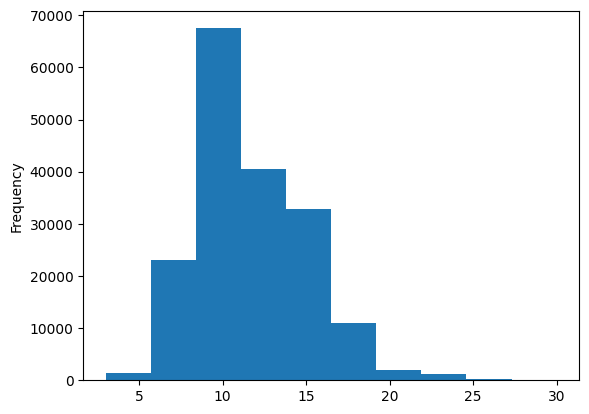

In [ ]:
# plotting the total_lines from train_df

train_df['total_lines'].plot.hist()
plt.show()

## conclusion:
* from looking at the above graph we can infer that most of the cohorts had 10-11 lines of sentences

## exploration,analysis and freethrows

In [ ]:
a = 'first:\t George is a Great Employee \n second:\t he will bring more profits to your business!'\
.splitlines()

a

['first:\t George is a Great Employee ',
 ' second:\t he will bring more profits to your business!']

In [ ]:
for text in a:
  print(text)

first:	 George is a Great Employee 
 second:	 he will bring more profits to your business!


In [ ]:
for text in a:
  text = text.split('\t')
  print(text[0])


first:
 second:


In [ ]:
for text in a:
  text = text.split('\t')
  print(text[1])


 George is a Great Employee 
 he will bring more profits to your business!


In [ ]:
get_lines(train_dir)

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
preprocess_text(get_lines(train_dir))

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
train_df.head(5)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


In [ ]:
len(train_df)

180040

In [ ]:
len('George is focused now!')

22

### make numeric labels(ML models require numeric labels)
* one-hot encode the target strings
* use the right string label in apt places of the one-hot matrix.

In [ ]:
# one-hot encoding

def one_hot_encode(df):
  """Args:
  for one-hot encoding the strings we need to have it in the form of integers so fill with
  numbers in all corresponding locations of the word's occurence

  naming convention:

  class_names: unique_types
  integer format: unique_int_types
  one hot format: one_hot_encoded

  """

  ## get the train target
  target_string_list = df['target']

  ## get the unique strins in a list
  unique_types , _ = tf.unique(target_string_list)

  ## get that in numpy form
  unique_types = unique_types.numpy()

  ## decode the strings in the list to remove the b prefix
  unique_types = [item.decode('utf-8') for item in unique_types]

  ## create a dictionary in which the words in unique_types should be the keys and integers their values
  unique_types_dic = {key:i for i,key in enumerate(unique_types)}

  ## now convert the whole train_df['target'] with these unique_types_dic to get unique_int_types
  unique_int_types = [unique_types_dic[item] for item in df['target']]

  one_hot_encoded = tf.one_hot(unique_int_types,depth=len(unique_types))

  return unique_types, unique_int_types, one_hot_encoded




## exploration,analysis and freethrows

In [ ]:
counter = 0
for item in train_df['target']:
  print(item)
  counter += 1

  if counter == 10:
    break

OBJECTIVE
METHODS
METHODS
METHODS
METHODS
METHODS
RESULTS
RESULTS
RESULTS
RESULTS


In [ ]:
train_df['target']

0           OBJECTIVE
1             METHODS
2             METHODS
3             METHODS
4             METHODS
             ...     
180035        RESULTS
180036        RESULTS
180037        RESULTS
180038    CONCLUSIONS
180039    CONCLUSIONS
Name: target, Length: 180040, dtype: object

In [ ]:
tf.unique(train_df['target'])

Unique(y=<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'OBJECTIVE', b'METHODS', b'RESULTS', b'CONCLUSIONS',
       b'BACKGROUND'], dtype=object)>, idx=<tf.Tensor: shape=(180040,), dtype=int32, numpy=array([0, 1, 1, ..., 2, 3, 3], dtype=int32)>)

In [ ]:
unique_types, _ = tf.unique(train_df['target']) # we don't want their indices
unique_types.numpy()

array([b'OBJECTIVE', b'METHODS', b'RESULTS', b'CONCLUSIONS',
       b'BACKGROUND'], dtype=object)

In [ ]:
list(unique_types.numpy())

[b'OBJECTIVE', b'METHODS', b'RESULTS', b'CONCLUSIONS', b'BACKGROUND']

In [ ]:
# remove the b's in infront

unique_types_list = [item.decode('utf-8') for item in list(unique_types.numpy()) ]
unique_types_list

['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND']

In [ ]:
type_to_int = {str_type:i for i,str_type in enumerate(unique_types_list)}

type_to_int

{'OBJECTIVE': 0, 'METHODS': 1, 'RESULTS': 2, 'CONCLUSIONS': 3, 'BACKGROUND': 4}

In [ ]:
int_list = [type_to_int[str_type] for str_type in train_df['target']]

# seeing only a little bit of it
int_list[:10]

[0, 1, 1, 1, 1, 1, 2, 2, 2, 2]

In [ ]:
# finally one-hot encoding
one_hot_encoded_target = tf.one_hot(int_list,depth=len(unique_types_list))

one_hot_encoded_target

<tf.Tensor: shape=(180040, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)>

# Experiments we are going to run are:

1. `model1`: naive_bayes tf-idf
2. `model2`: conv1D with Token embeddings
3. `model3`: Tensorflow Hub pretrained feature extractor.
4. `model4`: conv1D with character Embeddings
5. `model5`: pretrained Token Embeddings + Character Embeddings
6. `model6`: pretrained TabErroroken Embeddings + Character Embeddings + Positional Embeddins.

In [ ]:
# data
class_names, train_labels_int,train_labels_one_hot = one_hot_encode(train_df)
train_sentences = train_df['text']
class_names, test_labels_int,test_labels_one_hot = one_hot_encode(test_df)
test_sentences = test_df['text']
class_names, val_labels_int, val_labels_one_hot = one_hot_encode(val_df)
val_sentences = val_df['text']

# we are going to overwrite the labels_int with sklearn inbuilt label encoder since our
# model doesn't work well with our custom made train_labels_int
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_labels_int = lb.fit_transform(train_df['target'].to_numpy())
test_labels_int = lb.transform(test_df['target'].to_numpy())
val_labels_int = lb.transform(val_df['target'].to_numpy())


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model1 = Pipeline([
    ('tf-idf',TfidfVectorizer()),
    ('clf',MultinomialNB())
])

# fit the pipeline to the training data
model1.fit(train_sentences,train_labels_int)



Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# lets evaluate
model1.score(test_sentences,test_labels_int)

0.716674962667994

In [ ]:
# predictin on test_sentences
prediction = model1.predict(test_sentences)

prediction[:20]

array([2, 2, 2, 4, 4, 4, 4, 1, 4, 0, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4])

In [ ]:
actual = test_labels_int
actual[:20]

array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0, 0, 2, 2, 2, 4, 4, 4, 4, 4, 4])

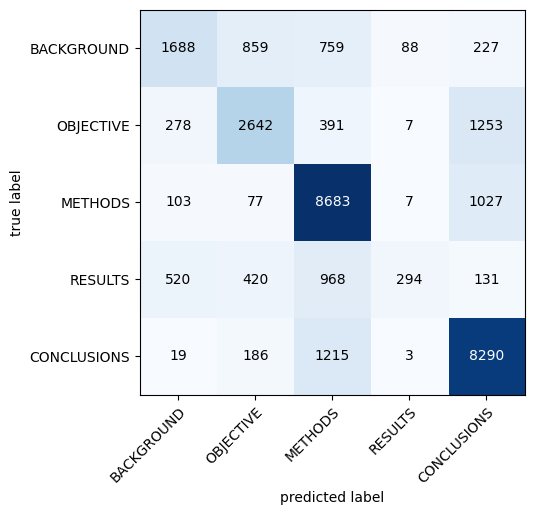

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(actual,prediction)
plot_confusion_matrix(cm,
                      figsize=(10,5),
                      class_names=class_names);

In [ ]:
model1_report = classification_report(actual,prediction)

print(model1_report)

              precision    recall  f1-score   support

           0       0.65      0.47      0.54      3621
           1       0.63      0.58      0.60      4571
           2       0.72      0.88      0.79      9897
           3       0.74      0.13      0.22      2333
           4       0.76      0.85      0.80      9713

    accuracy                           0.72     30135
   macro avg       0.70      0.58      0.59     30135
weighted avg       0.71      0.72      0.69     30135




## exploration,analysis and freethrows

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
just_see = label_encoder.fit_transform(train_df['target'].to_numpy())

In [ ]:
just_see[:20]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1, 0, 0, 3, 3, 2, 2, 2, 4])

In [ ]:
train_labels_int[:20]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1, 0, 0, 3, 3, 2, 2, 2, 4])

In [ ]:
train_df['target'][:20]

0       OBJECTIVE
1         METHODS
2         METHODS
3         METHODS
4         METHODS
5         METHODS
6         RESULTS
7         RESULTS
8         RESULTS
9         RESULTS
10        RESULTS
11    CONCLUSIONS
12     BACKGROUND
13     BACKGROUND
14      OBJECTIVE
15      OBJECTIVE
16        METHODS
17        METHODS
18        METHODS
19        RESULTS
Name: target, dtype: object

In [ ]:
text = 'George is hyper-focused now'
spl = text.split()
text,spl,len(spl)

('George is hyper-focused now', ['George', 'is', 'hyper-focused', 'now'], 4)

# model2: make the conv1d model yourself(token embedding)

## goals:
1. make a callback function
2. make a text vectorizer function.
3. make a embedding layer.
4. create the conv1d model
5. compile it and fit the data (don't forget to use the callback!).

In [ ]:
# 1. make a callback function
from pathlib import Path
def tensorboard(name):
  folder_name = Path('callbacks/tensorboard')
  file_path = folder_name / str(name)
  file_path.mkdir(parents=True,exist_ok=True)

  callback = tf.keras.callbacks.TensorBoard(log_dir=file_path)

  return callback




In [ ]:
# before we create the textvectorization layer we need to know the avg sentence length for
# for output sequence length

sentence_len = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sentence_len)
avg_sentence_len

26.338269273494777

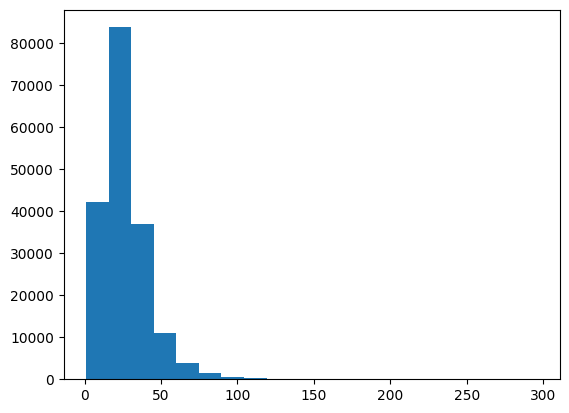

In [ ]:
plt.hist(sentence_len,bins=20);

In [ ]:
# what sentence length covers 95% of the examples?
int(np.percentile(sentence_len,95))

55

In [ ]:
# 2.make a TextVectorization layer
max_tokens = 65000 # as per the documentation.
output_sequence_length = 55
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,
                                                    standardize='lower_and_strip_punctuation',
                                                    split='whitespace',
                                                    ngrams=None,
                                                    output_mode='int',
                                                    output_sequence_length=output_sequence_length,
                                                    pad_to_max_tokens=True)

# 3.make the embedding layer
embedding = tf.keras.layers.Embedding(input_dim=max_tokens, # if you use mask_zero then increase the max_tokens + 1
                                      input_length=output_sequence_length,
                                      embeddings_initializer='uniform',
                                      output_dim=128,#batch size
                                      mask_zero=True)

In [ ]:
# adapting the text_vectorizer to train-sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# get the vocabulary length of train_sentences
unique_words = text_vectorizer.get_vocabulary()

print("\n Number of unique words in the data: {}".format(len(unique_words)))
print("\n Top 10 most appeared words: {}".format(unique_words[:10]))
print("\n Top 10 least appeared word: {}".format(unique_words[-10:]))


 Number of unique words in the data: 64841

 Top 10 most appeared words: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

 Top 10 least appeared word: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# experimenting with a random sentence
random_sentence = np.random.choice(train_sentences)
len_of_sentence = len(random_sentence.split())

print('\n our sentence is: {}'.format(random_sentence))
print("\n Length of our sentence is: {}".format(len_of_sentence))
print("\n Applying text vectorization: {}".format(text_vectorizer([random_sentence])))
print("\n Applying Embedding: {}".format(embedding(text_vectorizer([random_sentence]))))
print("\n Shape of our Embedded text: {}".format(embedding(text_vectorizer([random_sentence])).shape))


 our sentence is: a mean reduction of @ % ( @ ) ( @ % confidence interval -lsb- ci -rsb- , -@ to -@ , p = @ ) of the peak knee adduction moment and @ % ( @ ) ( @ % ci , -@ to -@ , p = @ ) of the moment arm at baseline was observed in the insole group when walking with an insole was compared with walking without an insole .

 Length of our sentence is: 76

 Applying text vectorization: [[   8   57  169    4  235  222   46   50   45    6   14    4    2  690
   517 8528 5341    3   50    6   14    4    2 5341  207   15   49   10
   148    5    2 7853   13  183  815    7   26 7853   10   34    7  815
   159   26 7853    0    0    0    0    0    0    0    0    0    0]]

 Applying Embedding: [[[ 0.04600701  0.02114034 -0.01164328 ...  0.00330941  0.04700141
   -0.01686193]
  [ 0.01355827 -0.03039373  0.01752222 ...  0.01207739  0.03886313
    0.04991405]
  [ 0.00926213  0.02752929  0.00442977 ... -0.0170268  -0.02453916
    0.04333263]
  ...
  [ 0.01683111 -0.02136049  0.04302711 ... -0.013

In [ ]:
# get addtional details about our text_vectorizer.
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None, None),
 'max_tokens': 65000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [ ]:
# making sure our data loads as fast as possible

# converting the data into tensors
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_int))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_int))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_int))


# setting the prefetching requirments for faster and smoother running
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# 4.create the conv1d layer
input_layer = tf.keras.layers.Input(shape=[1,],dtype=tf.string,name='inptut_layer')
x = text_vectorizer(input_layer)
x = embedding(x)
conv_layer = tf.keras.layers.Conv1D(filters=32,
                                    kernel_size=5,
                                    strides=1,
                                    activation='relu',
                                    padding='same')
x = conv_layer(x)
maxpool_layer = tf.keras.layers.GlobalMaxPool1D(name='GlobalMaxPool1D')(x)
output_layer = tf.keras.layers.Dense(len(class_names),activation='softmax',
                                     name='output_layer')(maxpool_layer)
model2 = tf.keras.Model(input_layer,output_layer)

# 5. compile the model
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# fitting the model
history2 = model2.fit(train_dataset,
                      epochs=5,
                      validation_data=val_dataset,
                      callbacks=tensorboard('model2_cnn'))

Epoch 1/5
5627/5627 [==============================] - 51s 9ms/step - loss: 0.5652 - accuracy: 0.7912 - val_loss: 0.4897 - val_accuracy: 0.8193
Epoch 2/5
5627/5627 [==============================] - 29s 5ms/step - loss: 0.3720 - accuracy: 0.8681 - val_loss: 0.5162 - val_accuracy: 0.8151
Epoch 3/5
5627/5627 [==============================] - 30s 5ms/step - loss: 0.2347 - accuracy: 0.9226 - val_loss: 0.5989 - val_accuracy: 0.8047
Epoch 4/5
5627/5627 [==============================] - 29s 5ms/step - loss: 0.1326 - accuracy: 0.9609 - val_loss: 0.7311 - val_accuracy: 0.7950
Epoch 5/5
5627/5627 [==============================] - 29s 5ms/step - loss: 0.0736 - accuracy: 0.9801 - val_loss: 0.9062 - val_accuracy: 0.7802


In [ ]:
# evaluating the test data
model2.evaluate(val_dataset)

945/945 [==============================] - 2s 2ms/step - loss: 0.9062 - accuracy: 0.7802


[0.9061881303787231, 0.780186653137207]

In [ ]:
# get the prediction probability array
model2_pred_probs = model2.predict(val_sentences)

model2_pred_probs,model2_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[8.0185972e-02, 9.4173878e-04, 8.8804554e-05, 9.0641874e-01,
         1.2364782e-02],
        [1.0197809e-01, 2.0366395e-03, 2.2974223e-06, 8.9598215e-01,
         7.2135271e-07],
        [1.3157188e-02, 4.5022321e-06, 5.7105986e-05, 9.8678118e-01,
         7.2823319e-08],
        ...,
        [2.6836888e-09, 4.5656876e-07, 2.0264882e-04, 8.5113612e-08,
         9.9979681e-01],
        [1.5470417e-06, 9.9325138e-01, 8.0677826e-04, 1.9864228e-05,
         5.9205340e-03],
        [1.0476660e-09, 9.9999952e-01, 9.3532126e-10, 2.0048039e-12,
         4.7926028e-07]], dtype=float32),
 (30212, 5))

In [ ]:
# get the pred_probs to preds
model2_pred_probs = model2.predict(val_sentences)
model2_predictions = tf.argmax(model2_pred_probs,axis=1)
actuals = val_labels_int

# print the classification report
model2_report = classification_report(actuals,model2_predictions)

print(model2_report)

945/945 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.62      0.53      0.57      3449
           1       0.69      0.72      0.70      4582
           2       0.89      0.85      0.87      9964
           3       0.58      0.54      0.56      2376
           4       0.81      0.88      0.85      9841

    accuracy                           0.78     30212
   macro avg       0.72      0.70      0.71     30212
weighted avg       0.78      0.78      0.78     30212



## exploration, analysis and freethrows

In [ ]:
class_names

['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
len(text_vectorizer.get_vocabulary())

64841

In [ ]:
a = 'george'
str(a)

'george'

In [ ]:
train_labels_one_hot

<tf.Tensor: shape=(180040, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)>

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# model3: Build TensorflowHub pretrained feature extractor layer(Token embedding)

## goals:
* refer the old notebooks on how to build it. you can also take help from online.
* the steps are:
       1. Build the feature extractor layer
       2. add a Dense layer(output layer) to assert the model to train for the number of classes you have in your problem.
       3. compile the model
       4. fit the model

In [ ]:
# # feature extractor layer

# # building the model in sequential style

# import tensorflow_hub as hub

# feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
#                                          input_shape=[],
#                                          dtype=tf.string,
#                                          trainable=False,
#                                          name='Feature_Extractor')


# # modifying the output layer
# model3 = tf.keras.Sequential([
#     feature_extractor_layer,
#     tf.keras.layers.Dense(64,activation='relu'),
#     tf.keras.layers.Dense(len(class_names),activation='softmax',name='output_layer')
# ])

# # compiling the model
# model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#                optimizer=tf.keras.optimizers.Adam(),
#                metrics=['accuracy'])

# # fit the model
# history3 = model3.fit(train_dataset,
#                       epochs=5,
#                       validation_data=val_dataset,
#                       callbacks=[tensorboard('model3_feature_extractor')])

In [ ]:
# building the model in functional API style
import tensorflow_hub as hub
feature_extractor_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',#universal sentence encoder
                                          trainable=False,
                                          dtype=tf.string,
                                          name='Feature_Extractor')

input_layer = tf.keras.Input(shape=[],dtype=tf.string,name='Input_Layer')

x = feature_extractor_layer(input_layer)

x = tf.keras.layers.Dense(64,activation='relu')(x)

output_layer = tf.keras.layers.Dense(len(class_names),activation='softmax',name='Output_Layer')(x)

model3 = tf.keras.Model(input_layer,output_layer)

# compiling the model
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# fit the model
history3 = model3.fit(train_dataset,
                      epochs=5,
                      validation_data=val_dataset,
                      callbacks=[tensorboard('model3_feature_extractor')])

Epoch 1/5
5627/5627 [==============================] - 61s 10ms/step - loss: 0.7506 - accuracy: 0.7126 - val_loss: 0.6773 - val_accuracy: 0.7425
Epoch 2/5
5627/5627 [==============================] - 57s 10ms/step - loss: 0.6584 - accuracy: 0.7499 - val_loss: 0.6414 - val_accuracy: 0.7560
Epoch 3/5
5627/5627 [==============================] - 57s 10ms/step - loss: 0.6270 - accuracy: 0.7623 - val_loss: 0.6242 - val_accuracy: 0.7629
Epoch 4/5
5627/5627 [==============================] - 56s 10ms/step - loss: 0.6074 - accuracy: 0.7696 - val_loss: 0.6148 - val_accuracy: 0.7659
Epoch 5/5
5627/5627 [==============================] - 56s 10ms/step - loss: 0.5938 - accuracy: 0.7749 - val_loss: 0.6100 - val_accuracy: 0.7692


In [ ]:
model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None,)]                 0         
                                                                 
 Feature_Extractor (KerasLa  (None, 512)               256797824 
 yer)                                                            
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 Output_Layer (Dense)        (None, 5)                 325       
                                                                 
Total params: 256830981 (979.73 MB)
Trainable params: 33157 (129.52 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# evaluating with val_dataset
model3.evaluate(val_dataset)

945/945 [==============================] - 7s 8ms/step - loss: 0.6100 - accuracy: 0.7692


[0.6100484132766724, 0.7691645622253418]

In [ ]:
# getting the prediction and actuals
pred_probs = model3.predict(val_dataset) # it automatically just take the val_sentences(x_test that is )
predictions = pred_probs.argmax(axis=1)
actuals = val_labels_int # val_labels_int is the y_test

model3_report  = classification_report(actuals,predictions)
print(model3_report)

945/945 [==============================] - 7s 8ms/step
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      3449
           1       0.67      0.65      0.66      4582
           2       0.83      0.86      0.85      9964
           3       0.76      0.45      0.57      2376
           4       0.81      0.86      0.83      9841

    accuracy                           0.77     30212
   macro avg       0.73      0.69      0.70     30212
weighted avg       0.77      0.77      0.77     30212



# model4: character embeddings


![fsfsfs](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-token-vs-character-embeddings.png)

In [ ]:
# split word level-data into char-level data
def split_char(sentence):
  return ' '.join(list(sentence))

# preparing the data
train_char = [split_char(sentence) for sentence in train_sentences]
val_char = [split_char(sentence) for sentence in val_sentences]
test_char = [split_char(sentence) for sentence in test_sentences]



In [ ]:
# average character length
char_len = [len(sentence) for sentence in train_sentences]
np.mean(char_len)

149.3662574983337

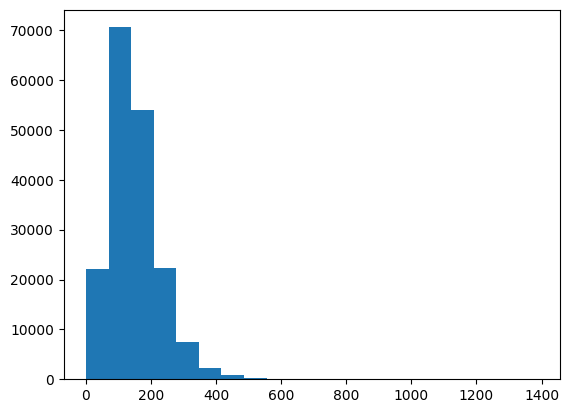

In [ ]:
# seeing the distribution of characters and their frequency
plt.hist(char_len,bins=20);

In [ ]:
# 95% of char lengths are?
np.percentile(char_len,95) # this is going to be our output_sequence_length

# anything above 290 will be truncated and anything below 290 will be masked with 0

290.0

In [ ]:
# getting max_tokens and output_sequence_length for our text_vectorizer
import string
max_tokens = len(string.ascii_lowercase ) + 2 # extra 2 is for: 1 for empty space and 1 for unknown tokens
output_sequence_length = int(np.percentile(char_len,95))

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,
                                                    output_sequence_length=output_sequence_length)


In [ ]:
# adapt text_vectorizer to train_char
text_vectorizer.adapt(train_char)

In [ ]:
# find the most common characters and least common chracters.
all_char = text_vectorizer.get_vocabulary()
print('Total characters are: %s'%(len(all_char)))
print('Most commonly appeared characters are: %s'%(all_char[:5]))
print('Least commonly appeared characters are: %s'%(all_char[-5:]))

Total characters are: 28
Most commonly appeared characters are: ['', '[UNK]', 'e', 't', 'i']
Least commonly appeared characters are: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# creating the embedding layer.
embedding = tf.keras.layers.Embedding(input_dim=len(all_char),
                                      input_length=output_sequence_length,
                                      embeddings_initializer='uniform',
                                      mask_zero=True,
                                      output_dim=25  ) # output_dim is determined in accordance with the document we are trying to imitate.




In [ ]:
# apply text vectorization and embedding to a random train_char
random_train_char = np.random.choice(train_char)
print(random_train_char)
print('Length of random_train_char: %s'%(len(random_train_char)))
print(text_vectorizer(random_train_char))
print(embedding(text_vectorizer(random_train_char)))

b e t w e e n - g r o u p   c o m p a r i s o n   r e v e a l e d   n o n s i g n i f i c a n t   d i f f e r e n c e s   (   p   =   <   @   )   b e t w e e n   t h e   s d m   s c o r e s   f o r   p r i v a t e l y   i n s u r e d   b l a c k   p a t i e n t s   v e r s u s   p r i v a t e l y   i n s u r e d   w h i t e   p a t i e n t s   ,   m e d i c a i d - i n s u r e d   w h i t e   p a t i e n t s   v e r s u s   m e d i c a i d - i n s u r e d   b l a c k   p a t i e n t s   ,   a n d   p r i v a t e l y   i n s u r e d   b l a c k   p a t i e n t s   v e r s u s   m e d i c a i d - i n s u r e d   b l a c k   p a t i e n t s   .
Length of random_train_char: 649
tf.Tensor(
[22  2  3 20  2  2  6 18  8  7 16 14 11  7 15 14  5  8  4  9  7  6  8  2
 21  2  5 12  2 10  6  7  6  9  4 18  6  4 17  4 11  5  6  3 10  4 17 17
  2  8  2  6 11  2  9 14 22  2  3 20  2  2  6  3 13  2  9 10 15  9 11  7
  8  2  9 17  7  8 14  8  4 21  5  3  2 12 19  4  6  9 16  8  2 10 22 12
  5 11 23 14  

In [ ]:
# creating the conv1D model
input_layer = tf.keras.Input(shape=[1,],dtype=tf.string,name='input_layer')
x = text_vectorizer(input_layer)
x = embedding(x)
conv1d_layer = tf.keras.layers.Conv1D(filters=32,
                           kernel_size=5,
                           strides=1,
                           activation='relu',
                           padding='same')

x = conv1d_layer(x)
x = tf.keras.layers.GlobalMaxPool1D(name='GlobalMaxPool1D')(x)
output_layer = tf.keras.layers.Dense(len(class_names),activation='softmax',name='output_layer')(x)

model4 = tf.keras.Model(input_layer,output_layer)

# compile the model
model4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# preparing the data
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_char,train_labels_int))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_char,test_labels_int))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_char,val_labels_int))

train_char_dataset = train_char_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_char_dataset = val_char_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# fit the model on the dataset
model4.fit(train_char_dataset,
           epochs=5,
           validation_data=val_char_dataset,
           callbacks=[tensorboard('model4_character_embed')])

Epoch 1/5
5627/5627 [==============================] - 26s 4ms/step - loss: 0.9717 - accuracy: 0.6145 - val_loss: 0.8475 - val_accuracy: 0.6673
Epoch 2/5
5627/5627 [==============================] - 24s 4ms/step - loss: 0.8293 - accuracy: 0.6779 - val_loss: 0.7957 - val_accuracy: 0.6898
Epoch 3/5
5627/5627 [==============================] - 25s 4ms/step - loss: 0.7955 - accuracy: 0.6918 - val_loss: 0.7808 - val_accuracy: 0.6976
Epoch 4/5
5627/5627 [==============================] - 26s 5ms/step - loss: 0.7807 - accuracy: 0.6986 - val_loss: 0.7746 - val_accuracy: 0.7013
Epoch 5/5
5627/5627 [==============================] - 26s 5ms/step - loss: 0.7709 - accuracy: 0.7025 - val_loss: 0.7686 - val_accuracy: 0.7032


In [ ]:
# getting the classification report:
from sklearn.metrics import classification_report

pred_probs = model4.predict(val_char_dataset) # it automatically selects only the sentences
predictions = pred_probs.argmax(axis=1)
actuals = val_labels_int

model4_report = classification_report(actuals,predictions)
print(model4_report)

945/945 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.52      0.47      0.50      3449
           1       0.59      0.53      0.56      4582
           2       0.79      0.80      0.80      9964
           3       0.59      0.43      0.50      2376
           4       0.73      0.83      0.78      9841

    accuracy                           0.70     30212
   macro avg       0.65      0.61      0.62     30212
weighted avg       0.70      0.70      0.70     30212



## exploration, analysis and freethrows

In [ ]:
# when you list a string it splits it into characters:
text = 'George is good'
list(text)

['G', 'e', 'o', 'r', 'g', 'e', ' ', 'i', 's', ' ', 'g', 'o', 'o', 'd']

In [ ]:
# joining the split chars together:
' '.join(list(text))

'G e o r g e   i s   g o o d'

In [ ]:
# count the number of characters in a sentence(len() counts each character)
len('George is good')


14

In [ ]:
# find all the alpha numeric characters in python:
import string
all_characters = string.ascii_lowercase + string.digits + string.punctuation
all_characters

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# find its length
len(all_characters)

68

In [ ]:
split_char(train_sentences[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

# model5: combining feature extraction + char_level_embedding

## goals:
* create a token-level embedding
* create a character-level embedding
* concatenate(combine) both of them.
* create a series of output layers(dense) on top of the concatenation.
* this model should take both token and character level sequences as inputs.

In [ ]:
# creating a model for words
import tensorflow_hub as hub
input_layer = tf.keras.Input(shape=[],dtype=tf.string,name='input_layer_words')
universal_sentence_encoder = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                            trainable=False,
                                            dtype=tf.string)
x = universal_sentence_encoder(input_layer)
output_layer = tf.keras.layers.Dense(296,activation='relu',name='output_layer_words')(x) # 296 neurons is arbitrary selection any number in multiples of 8 would do just fine
word_model = tf.keras.Model(input_layer,output_layer)

# creating a model for characters
max_tokens = 65000
output_sequence_length = 290
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,
                                                    output_sequence_length=output_sequence_length,
                                                    dtype=tf.string)
char_vectorizer.adapt(train_char)
char_embedding = tf.keras.layers.Embedding(input_dim=max_tokens,
                                           input_length=output_sequence_length,
                                           embeddings_initializer='uniform',
                                           output_dim=128,
                                           mask_zero=True)
input_layer = tf.keras.Input(shape=[1,],dtype=tf.string,name='input_layer_chars')
x = char_vectorizer(input_layer)
x = char_embedding(x)
output_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(x) # 24 is chosen as per the document we are trying to emulate
char_model = tf.keras.Model(input_layer,output_layer)


# lets concatenate

## lets concatenate
concatenate = tf.keras.layers.Concatenate(name='concatenation_layer')([
    word_model.output,
    char_model.output

])

## drop out some layers for regularization and avoid overfitting and for good generalization:
dropout = tf.keras.layers.Dropout(0.2)(concatenate)

## lets add a dense layer with 128 neurons(the # of neurons can be anything of your choice of multiples of 8):
dense = tf.keras.layers.Dense(128,activation='relu')(dropout)

## drop out some more layers:
dropout = tf.keras.layers.Dropout(0.2)(dense)

## lets finally create the output layer
output_layer = tf.keras.layers.Dense(len(class_names),activation='softmax',name='output_layer')(dropout)

## lets create the final combined model
model5 = tf.keras.Model(inputs=[word_model.input,char_model.input],outputs=output_layer)



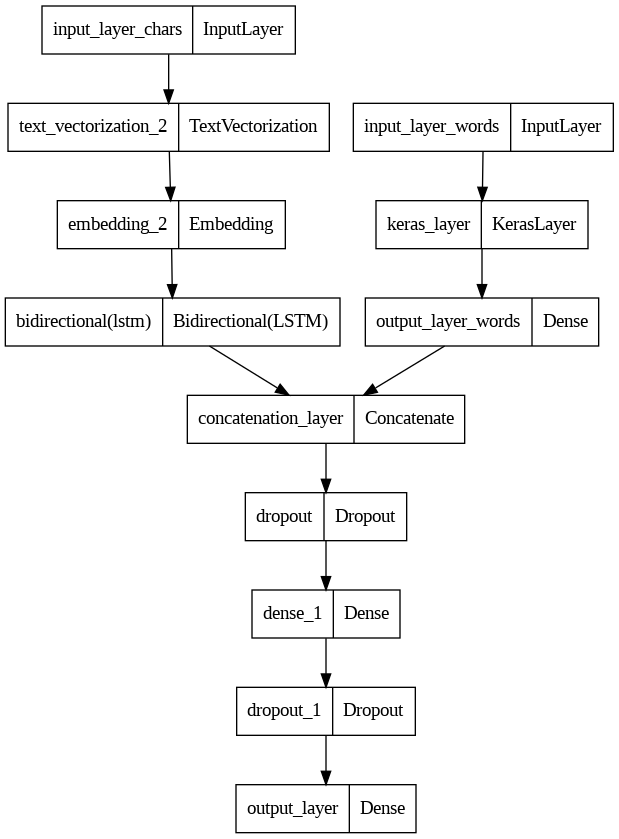

In [ ]:
from keras.utils import plot_model
plot_model(model5)

In [ ]:
# compile and fit the model
model5.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# fit the model

## preparing the data
train_word_char = tf.data.Dataset.from_tensor_slices((train_sentences,train_char))
train_word_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_int)
combined_train_dataset = tf.data.Dataset.zip((train_word_char,train_word_char_labels))

test_word_char_sentences = tf.data.Dataset.from_tensor_slices((test_sentences,test_char))
test_word_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_int)
combined_test_dataset = tf.data.Dataset.zip((test_word_char_sentences,test_word_char_labels))

val_word_char_sentences = tf.data.Dataset.from_tensor_slices((val_sentences,val_char))
val_word_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_int)
combined_val_dataset = tf.data.Dataset.zip((val_word_char_sentences,val_word_char_labels))

# optimizing for speed/faster compute
combined_train_dataset = combined_train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
combined_test_dataset = combined_test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
combined_val_dataset = combined_val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

## finally fit the data to the model
model5.fit(combined_train_dataset,
           epochs=5,
           steps_per_epoch = int(0.2*len(combined_train_dataset)),
           validation_data=combined_val_dataset,
           validation_steps = int(0.2* len(combined_val_dataset)),
           callbacks=[tensorboard('model5_feature_extraction_char_level_embedding')])

Epoch 1/5
1125/1125 [==============================] - 49s 34ms/step - loss: 0.7902 - accuracy: 0.6940 - val_loss: 0.6733 - val_accuracy: 0.7388
Epoch 2/5
1125/1125 [==============================] - 35s 31ms/step - loss: 0.6786 - accuracy: 0.7395 - val_loss: 0.6304 - val_accuracy: 0.7637
Epoch 3/5
1125/1125 [==============================] - 35s 31ms/step - loss: 0.6638 - accuracy: 0.7487 - val_loss: 0.6088 - val_accuracy: 0.7703
Epoch 4/5
1125/1125 [==============================] - 36s 32ms/step - loss: 0.6280 - accuracy: 0.7629 - val_loss: 0.5931 - val_accuracy: 0.7735
Epoch 5/5
1125/1125 [==============================] - 35s 31ms/step - loss: 0.6231 - accuracy: 0.7621 - val_loss: 0.5806 - val_accuracy: 0.7836


In [ ]:
# evaluating the whole dataset
model5.evaluate(combined_val_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.5858 - accuracy: 0.7771


[0.5858381390571594, 0.7771084308624268]

In [ ]:
# making the classification report
pred_probs = model5.predict(combined_val_dataset)
predictions = pred_probs.argmax(axis=1)
actuals = val_labels_int
model5_report = classification_report(actuals,predictions)
print(model5_report)

945/945 [==============================] - 14s 11ms/step
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      3449
           1       0.68      0.68      0.68      4582
           2       0.84      0.86      0.85      9964
           3       0.76      0.52      0.62      2376
           4       0.81      0.87      0.84      9841

    accuracy                           0.78     30212
   macro avg       0.74      0.70      0.72     30212
weighted avg       0.77      0.78      0.77     30212



# exploration,analyis and freethrows

In [ ]:
print(model2_report)

              precision    recall  f1-score   support

           0       0.62      0.53      0.57      3449
           1       0.69      0.72      0.70      4582
           2       0.89      0.85      0.87      9964
           3       0.58      0.54      0.56      2376
           4       0.81      0.88      0.85      9841

    accuracy                           0.78     30212
   macro avg       0.72      0.70      0.71     30212
weighted avg       0.78      0.78      0.78     30212



# conclusion:
* model2 conv1d layer with custom text vectorization seem to have outperformed all these additional complexities we have incorporated into building the model5. Quite surprising!!!!


# Model6: Feature extraction + character embedding + postional Embedding

* since our concatenation of word_model and char_model didn't work quite well. we are going to do postional embedding along with them.

![sdfsdfds](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-skimlit-overview-input-and-output.png)
## objective:
* we are going to use the line number and total lines (the information we have collected in the beginning of the preprocessing of textfile) to determine where would background go, and where would results go, where would conclusion go and so on.. Remember conclusion never comes before the background. Background, methods, results, conclusion must all come in order.
* take the line_number and total_lines to keep track of what in the abstract we are at.


## goals:
1. create a model for word
2. create a model for characters.
3. create a model for line number.
4. create a model for total_lines.
5. concatenate word model output and characters model output.
6. apply a regularization to dropout 0.2 of the neurons.
6. concatenate line_number model, total_lines model and the concatenation of word and characters model(concatenate 3,4,5).
7. create an output layer to accept all of this.
8. create the model with inputs = input of word,characters, line_number, total_lines, outputs = output_layer.


## do the following to use the label_smoothing:
* one_hot encode line_numbers
* one_hot_encode total_lines
* one_hot encode the targat labels.

## reasons for labels smoothing:
* The way language works is not merely a classification of words under different buckets to making sense of the context. Classification sure do exist but it doesn't take the wheel forever.

* For example when we worked with image classification tasks we get prediction probability array from the softmax function that comprised of something like this [0,0,0,0.99,0] here the number in the 4th index that is 1 will be considered but every other number besides it will be ignored

* what label smoothing does is it distributes the probability to the neighbors to make the above array look [0.2,0.2,0.2,0.91,0.2]. This is what label smoothing. what it implies is we are not sure whether the 4th index is the thing we want or searching for it could be that the other things could be the thing we were searching for as well. But selection still depends on the largest probability so the element in the index 4 with the largest probability 0.91 will be chosen over others.

* why do label smoothing though? I think it is due to the inherent uncertainty surrounding the language, usage of words, selection of words, construction of sentences and so on.. perhaps the selection of the next word I choose to write here is not completely fixed to any specific word and one word among myriads of words with different probability ratio is chosen aptly. kundi.




In [ ]:
# model for word with feature extractor(universal sentence encoder)
word_inputs = tf.keras.Input(shape=[],dtype=tf.string,name='word_input_layer')
import tensorflow_hub as hub
feature_extractor = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                   trainable=False,
                                   dtype=tf.string)

x = feature_extractor(word_inputs)
word_output_layer = tf.keras.layers.Dense(128,activation='relu',name='word_output_layer')(x) # 128 is in multiples of 8
word_model = tf.keras.Model(word_inputs,word_output_layer)

# model for characters
char_inputs = tf.keras.Input(shape=[1,],dtype=tf.string,name='char_input_layer') # 1 input at a time.
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=28,
                                                    output_sequence_length=290,
                                                    dtype=tf.string)
text_vectorizer.adapt(train_char)
embedding = tf.keras.layers.Embedding(input_dim=28, #as per document
                                      input_length=290, # 95% of character lengths in our data as per document
                                      embeddings_initializer='uniform',
                                      output_dim=128, # any number in multiples of 8
                                      mask_zero=True)

x = text_vectorizer(char_inputs)
x = embedding(x)
char_output_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x) # as per the document
char_model = tf.keras.Model(char_inputs,char_output_layer)


# line_number model
line_input_layer = tf.keras.Input(shape=(17,),dtype=tf.int64,name='line_number_input_layer') # one input at a time
line_output_layer = tf.keras.layers.Dense(32,activation='relu',name='line_number_output_layer')(line_input_layer)
line_number_model = tf.keras.Model(line_input_layer,line_output_layer)

# total_line model
total_line_input_layer = tf.keras.Input(shape=(21,),dtype=tf.int64,name='total_line_input_layer') # 1 input at a time
total_line_output_layer = tf.keras.layers.Dense(32,activation='relu',name='total_line_output_layer')(total_line_input_layer)
total_line_model = tf.keras.Model(total_line_input_layer,total_line_output_layer)

# concatenate word model outputs and char model outputs
concatenated = tf.keras.layers.Concatenate(name='word_char_concatenation')(
    [word_model.output,char_model.output]) # the order is important here

# regularization (dropping out 20% of neurons)
dropout = tf.keras.layers.Dropout(0.2)(concatenated)

# concatenate line_model, total_line model and the above concatenated.(w stands for whole or wholly)
w_concatenated = tf.keras.layers.Concatenate(name='concatenation_of_345')(
    [line_number_model.output,total_line_model.output,dropout])

# create an output layer
output_layer = tf.keras.layers.Dense(len(class_names),activation='softmax',name='output_layer')(w_concatenated)

# create the model
model6 = tf.keras.Model(inputs=(line_number_model.input,total_line_model.input,word_model.input,char_model.input),
                        outputs=output_layer)




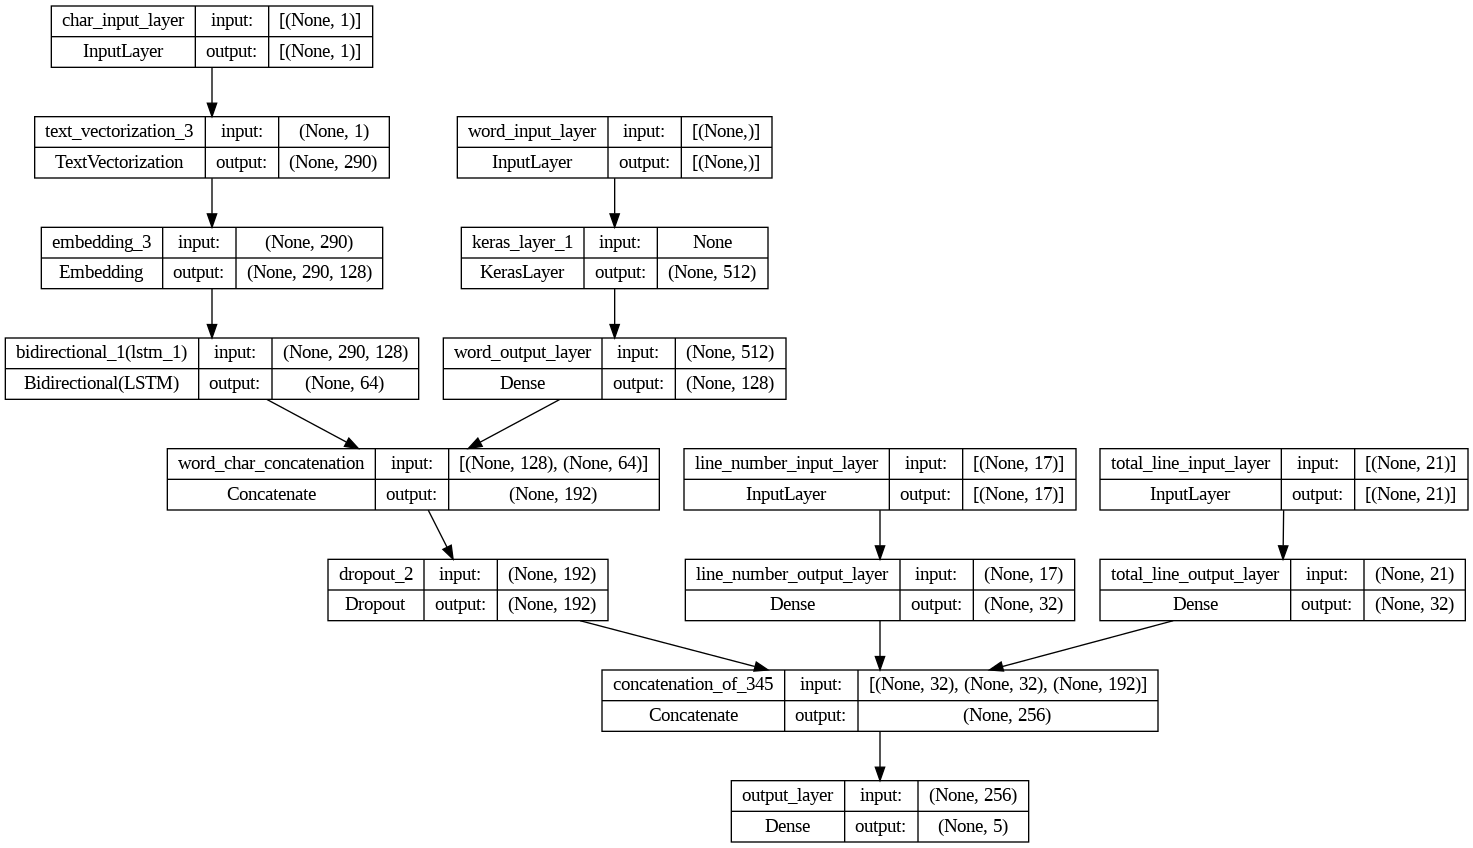

In [ ]:
from keras.utils import plot_model
plot_model(model6,show_shapes=True)

In [ ]:
# one-hot encode the neefuls: line_numbers,total_lines, labels.

## one-hot encoding the line_numbers
one_hot_line_numbers_train = tf.one_hot(train_df['line_number'].to_numpy(),depth=17)
one_hot_line_numbers_test = tf.one_hot(test_df['line_number'].to_numpy(),depth=17)
one_hot_line_numbers_val = tf.one_hot(val_df['line_number'].to_numpy(),depth=17)

## one-hot encoding the total_lines
one_hot_total_lines_train = tf.one_hot(train_df['total_lines'].to_numpy(),depth=21)
one_hot_total_lines_test = tf.one_hot(test_df['total_lines'].to_numpy(),depth=21)
one_hot_total_lines_val = tf.one_hot(val_df['total_lines'].to_numpy(),depth=21)


## one-hot encoding the labels
one_hot_train_labels = tf.one_hot(train_labels_int,depth=5)
one_hot_test_labels = tf.one_hot(test_labels_int,depth=5)
one_hot_val_labels = tf.one_hot(val_labels_int,depth=5)

# tensoring, batchifying and prefetching for performance boost:

## tensoring and packing
train_datasets = tf.data.Dataset.from_tensor_slices((one_hot_line_numbers_train,one_hot_total_lines_train,
                                                    train_sentences,train_char))
train_labels = tf.data.Dataset.from_tensor_slices(one_hot_train_labels)
combined_train_dataset = tf.data.Dataset.zip((train_datasets,train_labels))

val_datasets = tf.data.Dataset.from_tensor_slices((one_hot_line_numbers_val,one_hot_total_lines_val,
                                                    val_sentences,val_char))
val_labels = tf.data.Dataset.from_tensor_slices(one_hot_val_labels)
combined_val_dataset = tf.data.Dataset.zip((val_datasets,val_labels))

test_datasets = tf.data.Dataset.from_tensor_slices((one_hot_line_numbers_test,one_hot_total_lines_test,
                                                    test_sentences,test_char))
test_labels = tf.data.Dataset.from_tensor_slices(one_hot_test_labels)
combined_test_dataset = tf.data.Dataset.zip((test_datasets,test_labels))

## batchifying and prefetching
combined_train_dataset = combined_train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
combined_val_dataset   = combined_val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
combined_test_dataset  = combined_test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# compile and fit the model
model6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# fit the model
model6.fit(combined_train_dataset,
           epochs=5,
           steps_per_epoch=int(0.2*len(combined_train_dataset)),
           validation_data=combined_val_dataset,
           validation_steps=int(0.2*len(combined_val_dataset)),
           callbacks=tensorboard('model6_word_char_position_embedding'))

Epoch 1/5
1125/1125 [==============================] - 47s 33ms/step - loss: 1.0461 - accuracy: 0.7597 - val_loss: 0.9534 - val_accuracy: 0.8219
Epoch 2/5
1125/1125 [==============================] - 35s 31ms/step - loss: 0.9508 - accuracy: 0.8261 - val_loss: 0.9357 - val_accuracy: 0.8356
Epoch 3/5
1125/1125 [==============================] - 34s 30ms/step - loss: 0.9455 - accuracy: 0.8314 - val_loss: 0.9251 - val_accuracy: 0.8436
Epoch 4/5
1125/1125 [==============================] - 35s 31ms/step - loss: 0.9339 - accuracy: 0.8396 - val_loss: 0.9183 - val_accuracy: 0.8557
Epoch 5/5
1125/1125 [==============================] - 35s 31ms/step - loss: 0.9330 - accuracy: 0.8411 - val_loss: 0.9178 - val_accuracy: 0.8469


945/945 [==============================] - 13s 12ms/step
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      3449
           1       0.89      0.81      0.85      4582
           2       0.89      0.90      0.89      9964
           3       0.79      0.51      0.62      2376
           4       0.85      0.91      0.88      9841

    accuracy                           0.85     30212
   macro avg       0.83      0.79      0.80     30212
weighted avg       0.85      0.85      0.84     30212



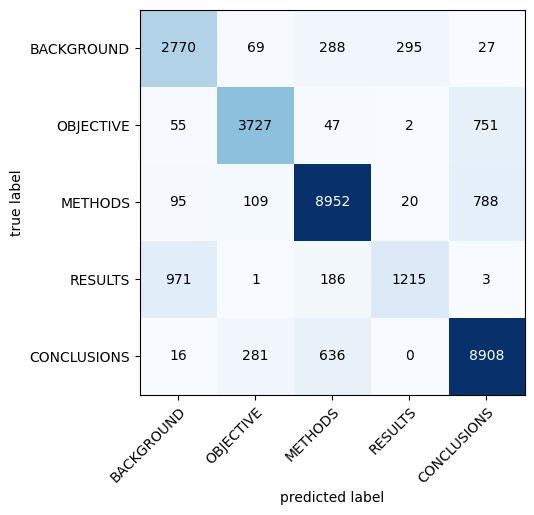

In [ ]:
# preparing cm and classification report
pred_probs = model6.predict(combined_val_dataset)
predictions = pred_probs.argmax(axis=1)
actuals = val_labels_int

from sklearn.metrics import confusion_matrix,classification_report
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(actuals,predictions)
plot_confusion_matrix(cm,
                      figsize=(10,5),
                      class_names=class_names)

model6_report = classification_report(actuals,predictions)
print(model6_report)

# exploration,analysis and freethrows

In [ ]:
len(np.unique(train_labels_int))

5

In [ ]:
train_df['line_number'].shape

(180040,)

In [ ]:
train_labels_int.shape

(180040,)

In [ ]:
one_hot_line_numbers_train[0].shape

TensorShape([17])

In [ ]:
train_df[20:30]

,line_number,target,text,total_lines
20,8,RESULTS,"yet , attention maintenance on food cues was s...",10
21,9,CONCLUSIONS,the current findings show that self-reported e...,10
22,10,CONCLUSIONS,results further suggest that attention mainten...,10
23,0,BACKGROUND,although working smoke alarms halve deaths in ...,14
24,1,BACKGROUND,we tested whether theory-based education incre...,14
25,2,METHODS,"randomised multiarm trial , with a single arm ...",14
26,3,METHODS,intervention arms : ( @ ) full education combi...,14
27,4,METHODS,four hundred and thirty-six homes recruited th...,14
28,5,METHODS,follow-up visits checked alarm operability in ...,14
29,6,METHODS,number of homes with working alarms defined as...,14


In [ ]:
train_df['line_number'][20:30]

20     8
21     9
22    10
23     0
24     1
25     2
26     3
27     4
28     5
29     6
Name: line_number, dtype: int64

In [ ]:
# shape of the line_number array
train_df['line_number'].shape

(180040,)

In [ ]:
# shape of one line_number
train_df['line_number'][0].shape

()

In [ ]:
# shape of one total_lines
train_df['total_lines'][0].shape

()

In [ ]:
# shape of one_char
np.array(train_char)[0].shape

()

In [ ]:
# dtype of one line_number
train_df['line_number'][0].dtype

dtype('int64')

In [ ]:
# dtype of one total lines
train_df['total_lines'][0].dtype

dtype('int64')

In [ ]:
# unique number of lines
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: >

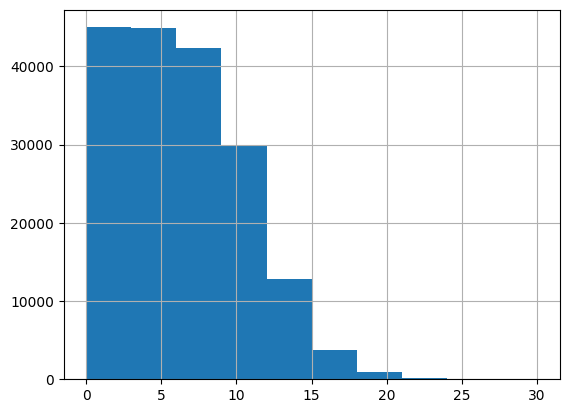

In [ ]:
# checking the distribution of lines
train_df['line_number'].hist()

In [ ]:
# 99% of our data has 17 lines
np.percentile(train_df['line_number'],99)

17.0

In [ ]:
# how many different number of lines are there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: >

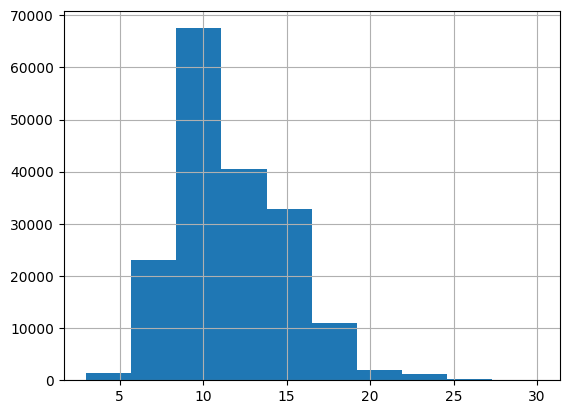

In [ ]:
# distribution for different number of total_lines
train_df['total_lines'].hist()

In [ ]:
# 99 % of total_lines are covered within?
np.percentile(train_df['total_lines'],99)

21.0

# compare our models

In [ ]:
print(model1_report)

              precision    recall  f1-score   support

           0       0.65      0.47      0.54      3621
           1       0.63      0.58      0.60      4571
           2       0.72      0.88      0.79      9897
           3       0.74      0.13      0.22      2333
           4       0.76      0.85      0.80      9713

    accuracy                           0.72     30135
   macro avg       0.70      0.58      0.59     30135
weighted avg       0.71      0.72      0.69     30135



In [ ]:
print(model2_report)

              precision    recall  f1-score   support

           0       0.62      0.53      0.57      3449
           1       0.69      0.72      0.70      4582
           2       0.89      0.85      0.87      9964
           3       0.58      0.54      0.56      2376
           4       0.81      0.88      0.85      9841

    accuracy                           0.78     30212
   macro avg       0.72      0.70      0.71     30212
weighted avg       0.78      0.78      0.78     30212



In [ ]:
print(model3_report)

              precision    recall  f1-score   support

           0       0.60      0.62      0.61      3449
           1       0.67      0.65      0.66      4582
           2       0.83      0.86      0.85      9964
           3       0.76      0.45      0.57      2376
           4       0.81      0.86      0.83      9841

    accuracy                           0.77     30212
   macro avg       0.73      0.69      0.70     30212
weighted avg       0.77      0.77      0.77     30212



In [ ]:
print(model4_report)

              precision    recall  f1-score   support

           0       0.52      0.47      0.50      3449
           1       0.59      0.53      0.56      4582
           2       0.79      0.80      0.80      9964
           3       0.59      0.43      0.50      2376
           4       0.73      0.83      0.78      9841

    accuracy                           0.70     30212
   macro avg       0.65      0.61      0.62     30212
weighted avg       0.70      0.70      0.70     30212



In [ ]:
print(model5_report)

              precision    recall  f1-score   support

           0       0.63      0.57      0.60      3449
           1       0.68      0.68      0.68      4582
           2       0.84      0.86      0.85      9964
           3       0.76      0.52      0.62      2376
           4       0.81      0.87      0.84      9841

    accuracy                           0.78     30212
   macro avg       0.74      0.70      0.72     30212
weighted avg       0.77      0.78      0.77     30212



In [ ]:
print(model6_report)

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      3449
           1       0.89      0.81      0.85      4582
           2       0.89      0.90      0.89      9964
           3       0.79      0.51      0.62      2376
           4       0.85      0.91      0.88      9841

    accuracy                           0.85     30212
   macro avg       0.83      0.79      0.80     30212
weighted avg       0.85      0.85      0.84     30212



# save and load the best performing model

## why save and load?
* we save and load the model so that we can have the model run in a different platform, place, environment,device ...

In [ ]:
saved_model = model6.save('skimlit_tribrid_model')
# loaded_model = tf.keras.models.load_model('sklimlit_tribrid_model')

TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/saving/legacy/saving_utils.py", line 147, in _wrapped_model  *
        outputs = model(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer 'model_15' (type Functional).
    
    Binding inputs to tf.function failed due to `missing a required argument: 'inputs'`. Received args: (<tf.Tensor 'word_input_layer:0' shape=(None,) dtype=string>,) and kwargs: {'training': False} for signature: (self, inputs, training=<captured_default_value>).
    
    Call arguments received by layer 'model_15' (type Functional):
      • inputs=('tf.Tensor(shape=(None, 17), dtype=int64)', 'tf.Tensor(shape=(None, 21), dtype=int64)', 'tf.Tensor(shape=(None,), dtype=string)', 'tf.Tensor(shape=(None, 1), dtype=string)')
      • training=False
      • mask=None


# MileStone project 2:


## goals:
1. use model6.
2. evaluate on the test_dataset.
3. find the top 3 wrong predictions with their probability.
4. find some data from RCT `https:\\pubmed.ncbi.nlm.nih.gov/ `and make prediction on them.

## extra:
1. download and load the pretrained model from google storage

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
# download the data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

In [ ]:
# download the model of mrdbourke from his google storage.
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2024-02-03 17:03:48--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.251, 172.217.164.27, 172.217.0.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  94.7MB/s    in 12s     

2024-02-03 17:04:01 (74.2 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skim

In [ ]:
# use T4 GPU device from hereon!